## Exercise 4: Data Warehouse Querying and Basic Geospatial Operations

Skills: 
* Query data warehouse table
* Use dictionary to map values

References: 
* https://docs.calitp.org/data-infra/analytics_new_analysts/05-spatial-analysis-basics.html
* https://docs.calitp.org/data-infra/analytics_new_analysts/06-spatial-analysis-intro.html
* https://docs.calitp.org/data-infra/analytics_new_analysts/07-spatial-analysis-intermediate.html
* https://github.com/jorisvandenbossche/geopandas-tutorial

To use `shared_utils`: 

> In the terminal: `cd ..` to be in the `_shared_utils` sub-folder, run `make setup_env`, then `cd` back into your task > sub-folder (e.g., `bus_service_increase` or `example_report`). 

In [1]:
import geopandas as gpd
import pandas as pd
import os

#os.environ["CALITP_BQ_MAX_BYTES"] = str(100_000_000_000)
pd.set_option("display.max_rows", 20)

from siuba import *
FOLDER = "../data/"
FILE_NAME = "exercise_4_stops_sample.parquet"
tbls=pd.read_parquet(f"{FOLDER}{FILE_NAME}")

In [2]:
tbls.head()

,feed_key,stop_id,stop_lat,stop_lon,stop_name
0,52639f09eb535f75b33d2c6a654cb89e,768641,37.228400,-120.248000,Le Grand @ Washington
1,25c6505166c01099b2f6f2de173e20b9,70042,37.655942,-122.404980,South San Francisco Caltrain Station
2,52639f09eb535f75b33d2c6a654cb89e,768584,37.301969,-120.488180,Transpo (Outside)
3,52639f09eb535f75b33d2c6a654cb89e,781926,37.330848,-120.558976,Gurr Rd @ Valley Dr
4,52639f09eb535f75b33d2c6a654cb89e,768416,37.349600,-120.587000,Juniper Ave @ Valley St (eastbound)


## Query a table, turn it into a gdf

You will query the warehouse table for 2 operators, Caltrain and Merced. A `feed_key` is a hash identifier, there's no real meaning to it, but it uniquely identifies a feed for that day.

The `feed_key` values for those 2 operators for 6/1/2022 are provided. 

* Query `mart_gtfs.dim_stops`
* Filter to the feed keys of interest
* Select these columns: `feed_key`, `stop_id`, `stop_lat`, `stop_lon`, `stop_name`
* Return as a dataframe using `collect()`
* Turn the point data into geometry with `geopandas`: [docs](https://geopandas.org/en/stable/docs/reference/api/geopandas.points_from_xy.html)

In [3]:
#Listing the feed_key for Caltrain and Merced
FEEDS = [
    "25c6505166c01099b2f6f2de173e20b9", # Caltrain
    "52639f09eb535f75b33d2c6a654cb89e", # Merced
]

stops = (
    tbls
    >> filter(_.feed_key.isin(FEEDS))
    >> select(_.feed_key, _.stop_id, 
             _.stop_lat, _.stop_lon, _.stop_name)
    >> arrange(_.feed_key, _.stop_id, 
               _.stop_lat, _.stop_lon)
    >> collect() 
)

In [4]:
print(stops)

                             feed_key      stop_id   stop_lat    stop_lon  \
134  25c6505166c01099b2f6f2de173e20b9  22nd_street  37.756972 -122.392492   
50   25c6505166c01099b2f6f2de173e20b9        70021  37.757599 -122.391880   
58   25c6505166c01099b2f6f2de173e20b9        70031  37.709537 -122.401586   
1    25c6505166c01099b2f6f2de173e20b9        70042  37.655942 -122.404980   
52   25c6505166c01099b2f6f2de173e20b9        70052  37.630461 -122.411709   
..                                ...          ...        ...         ...   
219  52639f09eb535f75b33d2c6a654cb89e       782486  36.981746 -120.627963   
19   52639f09eb535f75b33d2c6a654cb89e       782487  36.982797 -120.625370   
85   52639f09eb535f75b33d2c6a654cb89e       782489  36.992336 -120.626187   
22   52639f09eb535f75b33d2c6a654cb89e       844203  37.391296 -120.722486   
99   52639f09eb535f75b33d2c6a654cb89e       844204  37.058013 -120.822685   

                                stop_name  
134                           2

In [5]:
#Turn the point data into geodataframe with geopandas
stop_geometry= gpd.GeoDataFrame(
    stops, geometry=gpd.points_from_xy(stops.stop_lon, stops.stop_lat, crs="EPSG:4326"))

stop_geometry.head()

,feed_key,stop_id,stop_lat,stop_lon,stop_name,geometry
134,25c6505166c01099b2f6f2de173e20b9,22nd_street,37.756972,-122.392492,22nd Street,POINT (-122.39249 37.75697)
50,25c6505166c01099b2f6f2de173e20b9,70021,37.757599,-122.391880,22nd Street Caltrain Station,POINT (-122.39188 37.75760)
58,25c6505166c01099b2f6f2de173e20b9,70031,37.709537,-122.401586,Bayshore Caltrain Station,POINT (-122.40159 37.70954)
1,25c6505166c01099b2f6f2de173e20b9,70042,37.655942,-122.404980,South San Francisco Caltrain Station,POINT (-122.40498 37.65594)
52,25c6505166c01099b2f6f2de173e20b9,70052,37.630461,-122.411709,San Bruno Caltrain Station,POINT (-122.41171 37.63046)


## Use a dictionary to map values

* Create a new column called `operator` where `feed_key` is associated with its operator name.
* First, write a function to do it.
* Then, use a dictionary to do it (create new column called `agency`).
* Double check that `operator` and `agency` show the same values. Use `assert` to check.
    * `df.operator == df.agency` returns a series containing True/False for each row
    * `assert (df.operator == df.agency).all()` returns one result, False if it's not true, and nothing if it is True.
* Hint: https://docs.calitp.org/data-infra/analytics_new_analysts/02-data-analysis-intermediate.html

In [6]:
#making a new table as back up
stops_tbl = stops

#Function to set operator to agency
def operator_function(row):
    if row.feed_key == '52639f09eb535f75b33d2c6a654cb89e':
        return 'Merced'
    elif row.feed_key == '25c6505166c01099b2f6f2de173e20b9':
        return 'Caltrain'
    else:
        return 'other'
#New column for operator
stops_tbl['operator'] = stops.apply(operator_function, axis = 1)

#Using dictionary to set operator to agency
agency_dictionary={'52639f09eb535f75b33d2c6a654cb89e': 'Merced', '25c6505166c01099b2f6f2de173e20b9': 'Caltrain'}
#New column for agency
stops['agency'] = stops.feed_key.map(agency_dictionary)

print(stops_tbl)

                             feed_key      stop_id   stop_lat    stop_lon  \
134  25c6505166c01099b2f6f2de173e20b9  22nd_street  37.756972 -122.392492   
50   25c6505166c01099b2f6f2de173e20b9        70021  37.757599 -122.391880   
58   25c6505166c01099b2f6f2de173e20b9        70031  37.709537 -122.401586   
1    25c6505166c01099b2f6f2de173e20b9        70042  37.655942 -122.404980   
52   25c6505166c01099b2f6f2de173e20b9        70052  37.630461 -122.411709   
..                                ...          ...        ...         ...   
219  52639f09eb535f75b33d2c6a654cb89e       782486  36.981746 -120.627963   
19   52639f09eb535f75b33d2c6a654cb89e       782487  36.982797 -120.625370   
85   52639f09eb535f75b33d2c6a654cb89e       782489  36.992336 -120.626187   
22   52639f09eb535f75b33d2c6a654cb89e       844203  37.391296 -120.722486   
99   52639f09eb535f75b33d2c6a654cb89e       844204  37.058013 -120.822685   

                                stop_name  operator    agency  
134        

## Turn lat/lon into point geometry

* https://docs.calitp.org/data-infra/analytics_new_analysts/07-spatial-analysis-intermediate.html#create-geometry-column-from-latitude-and-longitude-coordinates
* There is a [function in shared_utils](https://github.com/cal-itp/data-analyses/blob/main/_shared_utils/shared_utils/geography_utils.py#L170-L192) that does it. Show the steps within the function (the long way), and also create the `geometry` column using `shared_utils`.
* Use `geography_utils.create_point_geometry??` to see what goes into that function, and what that function looks like under the hood.

In [7]:
# Rename columns
stops_tbl.rename(columns = {'stop_lon': 'longitude', 'stop_lat':'latitude'}, inplace=True)
stops_tbl.head(2)

,feed_key,stop_id,latitude,longitude,stop_name,operator,agency
134,25c6505166c01099b2f6f2de173e20b9,22nd_street,37.756972,-122.392492,22nd Street,Caltrain,Caltrain
50,25c6505166c01099b2f6f2de173e20b9,70021,37.757599,-122.391880,22nd Street Caltrain Station,Caltrain,Caltrain


In [8]:
# Create geometry column
geom_col = gpd.points_from_xy(stops_tbl.longitude, stops_tbl.latitude, crs="EPSG:4326")
stops_gdf = gpd.GeoDataFrame(stops_tbl, geometry=geom_col, crs = "EPSG:4326")

In [9]:
stops_gdf.head(2)

,feed_key,stop_id,latitude,longitude,stop_name,operator,agency,geometry
134,25c6505166c01099b2f6f2de173e20b9,22nd_street,37.756972,-122.392492,22nd Street,Caltrain,Caltrain,POINT (-122.39249 37.75697)
50,25c6505166c01099b2f6f2de173e20b9,70021,37.757599,-122.391880,22nd Street Caltrain Station,Caltrain,Caltrain,POINT (-122.39188 37.75760)


Basic stuff about a geodataframe.

A gdf would have a coordinate reference system that converts the points or lines into a place on the spherical Earth. The most common CRS is called `WGS 84`, and its code is `EPSG:4326`. This is what you'd see when you use Google Maps to find lat/lon of a place.

[Read](https://desktop.arcgis.com/en/arcmap/latest/map/projections/about-geographic-coordinate-systems.htm) about the `WGS 84` geographic coordinate system.

[Read](https://desktop.arcgis.com/en/arcmap/latest/map/projections/about-projected-coordinate-systems.htm) about projected coordinate reference systems, which is essentially about flattening our spherical Earth into a 2D plane so we can measure distances and whatnot.

* Is it a pandas dataframe or a geopandas geodataframe?: `type(gdf)`
* Coordinate reference system: `gdf.crs`
* gdfs must have a geometry column. Find the name of the column that is geometry: `gdf.geometry.name`
* Project the coordinate reference system to something else: `gdf = gdf.to_crs("EPSG:2229")` and check.

In [10]:
# checking whether the table is a pandas dataframe or a geopandas geodataframe
type(stops_gdf)

geopandas.geodataframe.GeoDataFrame

In [11]:
#checking coordinate reference system
stops_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
#Finding the name of the column that contains the geometry
stops_gdf.geometry.name

'geometry'

* This GitHub repo has several `geopandas` tutorials that covers basic spatial concepts: https://github.com/jorisvandenbossche/geopandas-tutorial. 
* Skim through the notebooks to see some of the concepts demonstrated, although to actually run the notebooks, you can click on `launch binder` in the repo's README to do so.

In [13]:
#Project the coordinate reference system to something else
stops_gdf = stops_gdf.to_crs("EPSG:2229") 

#And check
stops_gdf.crs

<Projected CRS: EPSG:2229>
Name: NAD83 / California zone 5 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties Kern; Los Angeles; San Bernardino; San Luis Obispo; Santa Barbara; Ventura.
- bounds: (-121.42, 32.76, -114.12, 35.81)
Coordinate Operation:
- name: SPCS83 California zone 5 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

## Spatial Join (which points fall into which polygon)

This URL gives you CA county boundaries: https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-county-boundaries/explore?location=37.246136%2C-119.002032%2C6.12

* Go to "I want to use this" > View API Resources > copy link for geojson
* Read in the geojson with `geopandas` and make it a geodataframe: `gpd.read_file(LONG_URL_PATH)`
* Double check that the coordinate reference system is the same for both gdfs using `gdf.crs`. If not, change it so they are the same.
* Spatial join stops to counties: [docs](https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin.html)
    * Play with inner join or left join, what's the difference? Which one do you want?
    * Play with switching around the left_df and right_df, what's the right order?
* By county: count number of stops and stops per sq_mi.
    * Hint 1: Start with a CRS with units in feet or meters, then do a conversion to sq mi. [CRS in shared_utils](https://github.com/cal-itp/data-analyses/blob/main/_shared_utils/shared_utils/geography_utils.py)
    * Hint 2: to find area, you can create a new column and calculate `gdf.geometry.area`. [geometry manipulations docs](https://geopandas.org/en/stable/docs/user_guide/geometric_manipulations.html)

In [14]:
#Read CA county boundaries geojson with geopandas and make it a geodataframe
CA_Counties = gpd.read_file('https://services1.arcgis.com/jUJYIo9tSA7EHvfZ/arcgis/rest/services/California_County_Boundaries/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson')
CA_Counties.head(2)

,OBJECTID,COUNTY_NAME,COUNTY_ABBREV,COUNTY_NUM,COUNTY_CODE,COUNTY_FIPS,ISLAND,Shape__Area,Shape__Length,GlobalID,geometry
0,1,Alameda,ALA,1,01,001,NaN,3.402787e+09,308998.650766,e6f92268-d2dd-4cfb-8b79-5b4b2f07c559,"POLYGON ((-122.27125 37.90503, -122.27024 37.9..."
1,2,Alpine,ALP,2,02,003,NaN,3.146939e+09,274888.492411,870479b2-480a-494b-8352-ad60578839c1,"POLYGON ((-119.58667 38.71420, -119.58653 38.7..."


In [15]:
#Double check that the coordinate reference system is the same for both gdfs using 
CA_Counties.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [16]:
#Project stops_gdf the coordinate reference system to EPSG:4326 so it matches CA_Counties
stops_gdf = stops_gdf.to_crs("EPSG:4326")
stops_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [17]:
#Spatially join stops to counties

##Play with inner join or left join, what's the difference? Which one do you want?

##The type of join:
###‘left’: use keys from left_df; retain only left_df geometry column
###‘right’: use keys from right_df; retain only right_df geometry column
###‘inner’: use intersection of keys from both dfs; retain only left_df geometry column

##Play with switching around the left_df and right_df, what's the right order?

<AxesSubplot:>

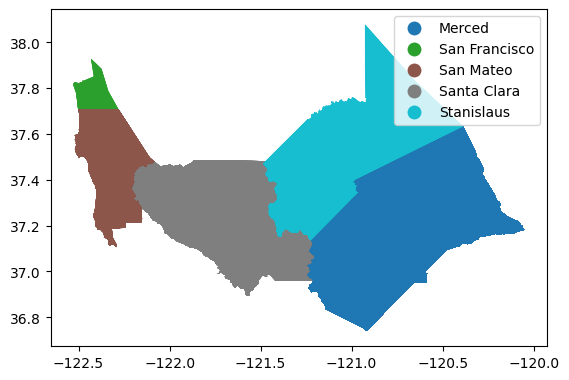

In [18]:
#inner join
#"‘inner’: use intersection of keys from both dfs; retain only left_df geometry column"
stops_county_inner = gpd.sjoin(CA_Counties, stops_gdf, how = 'inner', predicate = 'intersects')
stops_county_inner.plot(column="COUNTY_NAME", legend=True)

<AxesSubplot:>

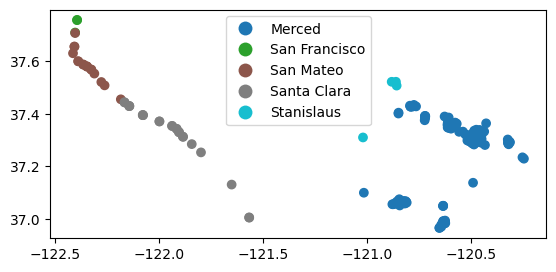

In [20]:
#right join
#"‘right’: use keys from right_df; retain only right_df geometry column"
stops_county_right = gpd.sjoin(CA_Counties, stops_gdf, how = 'right', predicate = 'intersects')
stops_county_right.plot(column="COUNTY_NAME", legend=True)

<AxesSubplot:>

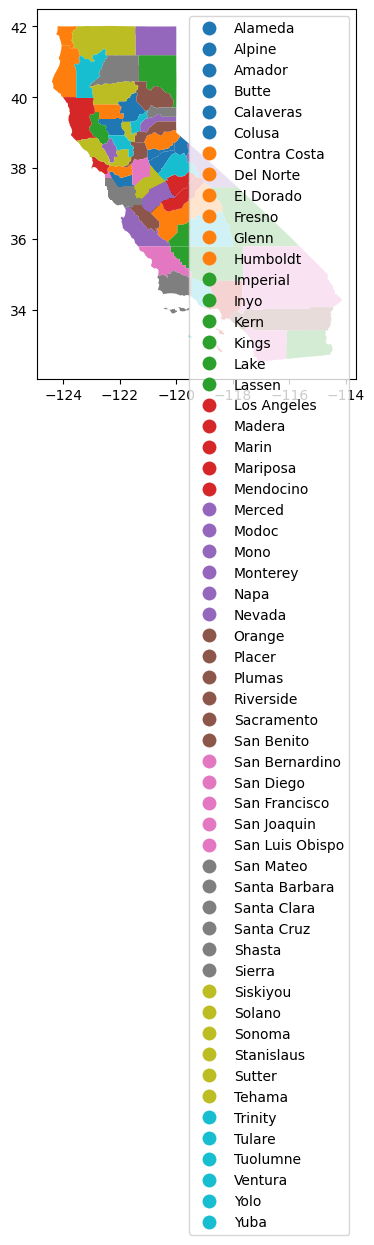

In [19]:
#left join -- guessing this one is the correct join but I'm not totally sure why
#"‘left’: use keys from left_df; retain only left_df geometry column"
stops_county_left = gpd.sjoin(CA_Counties, stops_gdf, how = 'left', predicate = 'intersects')
stops_county_left.plot(column="COUNTY_NAME", legend=True)

In [ ]:
#By county: count number of stops and stops per sq_mi.
##Hint 1: Start with a CRS with units in feet or meters, then do a conversion to sq mi. CRS in shared_utils
##Hint 2: to find area, you can create a new column and calculate gdf.geometry.area. geometry manipulations docs

In [23]:
stops_county_left.head(2)

,OBJECTID,COUNTY_NAME,COUNTY_ABBREV,COUNTY_NUM,COUNTY_CODE,COUNTY_FIPS,ISLAND,Shape__Area,Shape__Length,GlobalID,geometry,index_right,feed_key,stop_id,latitude,longitude,stop_name,operator,agency
0,1,Alameda,ALA,1,01,001,NaN,3.402787e+09,308998.650766,e6f92268-d2dd-4cfb-8b79-5b4b2f07c559,"POLYGON ((-122.27125 37.90503, -122.27024 37.9...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Alpine,ALP,2,02,003,NaN,3.146939e+09,274888.492411,870479b2-480a-494b-8352-ad60578839c1,"POLYGON ((-119.58667 38.71420, -119.58653 38.7...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
stops_county_left_ft = stops_county_left.to_crs("EPSG:2229")
stops_county_left_ft

,OBJECTID,COUNTY_NAME,COUNTY_ABBREV,COUNTY_NUM,COUNTY_CODE,COUNTY_FIPS,ISLAND,Shape__Area,Shape__Length,GlobalID,geometry,index_right,feed_key,stop_id,latitude,longitude,stop_name,operator,agency
0,1,Alameda,ALA,1,01,001,NaN,3.402787e+09,308998.650766,e6f92268-d2dd-4cfb-8b79-5b4b2f07c559,"POLYGON ((5327843.636 3270649.517, 5328125.534...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Alpine,ALP,2,02,003,NaN,3.146939e+09,274888.492411,870479b2-480a-494b-8352-ad60578839c1,"POLYGON ((6107872.113 3543254.346, 6107910.593...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Amador,AMA,3,03,005,NaN,2.562635e+09,361708.438013,4f45b3a6-be10-461c-8945-6b2aaa7119f6,"POLYGON ((5968863.196 3541606.326, 5968719.695...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Butte,BUT,4,04,007,NaN,7.339348e+09,526547.115238,44fba680-aecc-4e04-a499-29d69affbd4a,"POLYGON ((5691714.322 3875581.366, 5690777.192...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Calaveras,CAL,5,05,009,NaN,4.351069e+09,370637.578323,d11ef739-4a1e-414e-bfd1-e7dcd56cd61e,"POLYGON ((5982508.552 3443893.703, 5982516.557...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,65,Ventura,VEN,56,56,111,Channel Islands,8.750094e+05,11880.900594,86c2171f-d249-45a0-ac0c-40a4e6cb82e2,"POLYGON ((6143046.450 1829320.572, 6143046.239...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,66,Ventura,VEN,56,56,111,Channel Islands,2.595855e+06,14258.527110,71e2d2ad-a83c-4f5d-bc3b-b7ad9b12f57b,"POLYGON ((6127477.177 1831300.318, 6127492.624...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,67,Ventura,VEN,56,56,111,Channel Islands,6.082082e+05,7967.029762,d90412b1-c6af-4437-94d9-48dc3a13a64d,"POLYGON ((6148249.294 1831304.903, 6148250.818...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,68,Los Angeles,LOS,19,19,037,Channel Islands,2.076580e+08,135274.201204,3cb33dc3-e564-4bbf-8528-866600a1f9e4,"POLYGON ((6396332.058 1451624.979, 6396355.692...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
stops_county_left_ft.crs

<Projected CRS: EPSG:2229>
Name: NAD83 / California zone 5 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties Kern; Los Angeles; San Bernardino; San Luis Obispo; Santa Barbara; Ventura.
- bounds: (-121.42, 32.76, -114.12, 35.81)
Coordinate Operation:
- name: SPCS83 California zone 5 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich